# Rated DPG for Cartpole


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/aras/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [6]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.91213468440549 -3.0444881174756406
actions: 1 0
rewards: 1.0 1.0


In [7]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [8]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [9]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [10]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [11]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [12]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [13]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob * targetQs) # DPG: r+(gamma*nextQ)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True) # Qs
    rates = tf.reshape(rates, shape=[-1, 1])
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=rates)) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                     labels=rates)) # 0-1
    dlossA /= 2
    dlossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ += tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    dlossQ /= 2
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [14]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [15]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [16]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [17]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [18]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [19]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [20]:
goal = 500
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done), -1])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/goal
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        num_step = 0 # reset

In [21]:
idx = np.random.choice(np.arange(memory_size// batch_size))
batch = np.array(memory.buffer)[idx*batch_size:(idx+1)*batch_size]
rates = np.array([each[5] for each in batch])
batch = batch[rates >= (np.max(rates)*0.9)]
states = np.array([each[0] for each in batch])
actions = np.array([each[1] for each in batch])
next_states = np.array([each[2] for each in batch])
rewards = np.array([each[3] for each in batch])
dones = np.array([each[4] for each in batch])
rates = np.array([each[5] for each in batch])

In [22]:
batch.shape, \
states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape

((70, 6), (70, 4), (70,), (70, 4), (70,), (70,), (70,))

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [24]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dlossA_list, dlossQ_list = [], [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111):
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        total_reward = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), -1])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the last played episode
            if done is True:
                rate = total_reward/ goal # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][5] == -1: # double-check if it is empty and it is not rated!
                        memory.buffer[-1-idx][5] = rate # rate each SA pair
            
            # Training using a max rated batch
            idx = np.random.choice(np.arange(memory_size// batch_size))
            batch = np.array(memory.buffer)[idx*batch_size:(idx+1)*batch_size]
            rates = np.array([each[5] for each in batch])
            batch = batch[rates >= (np.max(rates)*0.9)]
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            rates = np.array([each[5] for each in batch])            
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            gloss, dlossA, dlossQ, _, _, _ = sess.run([model.g_loss, model.d_lossA, model.d_lossQ, 
                                                       model.g_opt, model.d_optA, model.d_optQ],
                                                      feed_dict = {model.states: states, 
                                                                   model.actions: actions,
                                                                   model.targetQs: targetQs, 
                                                                   model.rates: rates})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dlossA_list.append([ep, np.mean(dlossA_batch)])
        dlossQ_list.append([ep, np.mean(dlossQ_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= goal:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:19.0000 R:19.0000 rate:0.0380 gloss:0.5889 dlossA:0.6665 dlossQ:0.8911 exploreP:0.9981
Episode:1 meanR:18.0000 R:17.0000 rate:0.0340 gloss:0.5847 dlossA:0.6643 dlossQ:0.8937 exploreP:0.9964
Episode:2 meanR:16.0000 R:12.0000 rate:0.0240 gloss:0.5954 dlossA:0.6641 dlossQ:0.8999 exploreP:0.9953
Episode:3 meanR:20.0000 R:32.0000 rate:0.0640 gloss:0.5864 dlossA:0.6645 dlossQ:0.8963 exploreP:0.9921
Episode:4 meanR:19.0000 R:15.0000 rate:0.0300 gloss:0.5752 dlossA:0.6645 dlossQ:0.8888 exploreP:0.9906
Episode:5 meanR:19.5000 R:22.0000 rate:0.0440 gloss:0.5992 dlossA:0.6710 dlossQ:0.9079 exploreP:0.9885
Episode:6 meanR:18.4286 R:12.0000 rate:0.0240 gloss:0.5814 dlossA:0.6677 dlossQ:0.8875 exploreP:0.9873
Episode:7 meanR:19.2500 R:25.0000 rate:0.0500 gloss:0.5904 dlossA:0.6725 dlossQ:0.8993 exploreP:0.9849
Episode:8 meanR:18.8889 R:16.0000 rate:0.0320 gloss:0.5946 dlossA:0.6686 dlossQ:0.8992 exploreP:0.9833
Episode:9 meanR:18.5000 R:15.0000 rate:0.0300 gloss:0.5973 dlossA:0.6720 

Episode:79 meanR:26.4875 R:23.0000 rate:0.0460 gloss:0.5538 dlossA:0.6641 dlossQ:0.9031 exploreP:0.8110
Episode:80 meanR:26.4074 R:20.0000 rate:0.0400 gloss:0.5549 dlossA:0.6654 dlossQ:0.8920 exploreP:0.8094
Episode:81 meanR:26.4634 R:31.0000 rate:0.0620 gloss:0.5567 dlossA:0.6648 dlossQ:0.9000 exploreP:0.8069
Episode:82 meanR:26.3373 R:16.0000 rate:0.0320 gloss:0.5466 dlossA:0.6604 dlossQ:0.8935 exploreP:0.8056
Episode:83 meanR:26.4881 R:39.0000 rate:0.0780 gloss:0.5492 dlossA:0.6630 dlossQ:0.8921 exploreP:0.8025
Episode:84 meanR:26.6941 R:44.0000 rate:0.0880 gloss:0.5627 dlossA:0.6685 dlossQ:0.9057 exploreP:0.7990
Episode:85 meanR:27.0349 R:56.0000 rate:0.1120 gloss:0.5646 dlossA:0.6675 dlossQ:0.9106 exploreP:0.7946
Episode:86 meanR:27.7931 R:93.0000 rate:0.1860 gloss:0.5572 dlossA:0.6638 dlossQ:0.9067 exploreP:0.7874
Episode:87 meanR:27.9091 R:38.0000 rate:0.0760 gloss:0.5625 dlossA:0.6645 dlossQ:0.9031 exploreP:0.7844
Episode:88 meanR:27.9663 R:33.0000 rate:0.0660 gloss:0.5579 dlos

Episode:158 meanR:51.5800 R:85.0000 rate:0.1700 gloss:0.6045 dlossA:0.6796 dlossQ:0.9598 exploreP:0.5225
Episode:159 meanR:51.6900 R:32.0000 rate:0.0640 gloss:0.5983 dlossA:0.6788 dlossQ:0.9887 exploreP:0.5209
Episode:160 meanR:51.7800 R:30.0000 rate:0.0600 gloss:0.6088 dlossA:0.6795 dlossQ:0.9632 exploreP:0.5193
Episode:161 meanR:52.9000 R:131.0000 rate:0.2620 gloss:0.6061 dlossA:0.6809 dlossQ:0.9631 exploreP:0.5127
Episode:162 meanR:52.7200 R:54.0000 rate:0.1080 gloss:0.6021 dlossA:0.6804 dlossQ:0.9621 exploreP:0.5100
Episode:163 meanR:52.2000 R:12.0000 rate:0.0240 gloss:0.5959 dlossA:0.6791 dlossQ:0.9578 exploreP:0.5094
Episode:164 meanR:52.8200 R:85.0000 rate:0.1700 gloss:0.6040 dlossA:0.6803 dlossQ:0.9656 exploreP:0.5052
Episode:165 meanR:52.6400 R:61.0000 rate:0.1220 gloss:0.6111 dlossA:0.6821 dlossQ:0.9668 exploreP:0.5022
Episode:166 meanR:53.6300 R:140.0000 rate:0.2800 gloss:0.6083 dlossA:0.6801 dlossQ:0.9713 exploreP:0.4953
Episode:167 meanR:55.0400 R:155.0000 rate:0.3100 glos

Episode:236 meanR:103.5100 R:146.0000 rate:0.2920 gloss:0.6667 dlossA:0.7061 dlossQ:1.0050 exploreP:0.2304
Episode:237 meanR:104.4400 R:123.0000 rate:0.2460 gloss:0.6642 dlossA:0.7063 dlossQ:1.0113 exploreP:0.2277
Episode:238 meanR:104.2400 R:90.0000 rate:0.1800 gloss:0.6663 dlossA:0.7080 dlossQ:1.0073 exploreP:0.2258
Episode:239 meanR:104.6100 R:104.0000 rate:0.2080 gloss:0.6607 dlossA:0.7072 dlossQ:1.0119 exploreP:0.2236
Episode:240 meanR:105.0000 R:86.0000 rate:0.1720 gloss:0.6716 dlossA:0.7093 dlossQ:1.0094 exploreP:0.2217
Episode:241 meanR:105.4700 R:152.0000 rate:0.3040 gloss:0.6652 dlossA:0.7095 dlossQ:1.0081 exploreP:0.2185
Episode:242 meanR:106.2800 R:119.0000 rate:0.2380 gloss:0.6667 dlossA:0.7091 dlossQ:1.0100 exploreP:0.2161
Episode:243 meanR:106.3900 R:102.0000 rate:0.2040 gloss:0.6701 dlossA:0.7097 dlossQ:1.0107 exploreP:0.2140
Episode:244 meanR:107.8400 R:171.0000 rate:0.3420 gloss:0.6745 dlossA:0.7131 dlossQ:1.0144 exploreP:0.2105
Episode:245 meanR:107.9800 R:114.0000 r

Episode:313 meanR:146.7600 R:114.0000 rate:0.2280 gloss:0.8159 dlossA:0.7897 dlossQ:1.0170 exploreP:0.0774
Episode:314 meanR:145.8400 R:122.0000 rate:0.2440 gloss:0.8127 dlossA:0.7879 dlossQ:0.9992 exploreP:0.0766
Episode:315 meanR:147.4400 R:250.0000 rate:0.5000 gloss:0.8172 dlossA:0.7869 dlossQ:1.0185 exploreP:0.0750
Episode:316 meanR:148.9500 R:234.0000 rate:0.4680 gloss:0.8264 dlossA:0.7937 dlossQ:1.0133 exploreP:0.0735
Episode:317 meanR:148.8600 R:121.0000 rate:0.2420 gloss:0.8300 dlossA:0.7938 dlossQ:1.0152 exploreP:0.0727
Episode:318 meanR:148.6600 R:102.0000 rate:0.2040 gloss:0.8301 dlossA:0.7963 dlossQ:1.0132 exploreP:0.0721
Episode:319 meanR:148.4800 R:88.0000 rate:0.1760 gloss:0.8303 dlossA:0.7993 dlossQ:1.0168 exploreP:0.0715
Episode:320 meanR:148.1200 R:140.0000 rate:0.2800 gloss:0.8241 dlossA:0.7965 dlossQ:1.0102 exploreP:0.0707
Episode:321 meanR:149.6400 R:241.0000 rate:0.4820 gloss:0.8248 dlossA:0.7956 dlossQ:1.0154 exploreP:0.0692
Episode:322 meanR:150.8500 R:217.0000 

Episode:390 meanR:216.0700 R:316.0000 rate:0.6320 gloss:1.4335 dlossA:1.1419 dlossQ:1.0516 exploreP:0.0217
Episode:391 meanR:217.8900 R:304.0000 rate:0.6080 gloss:1.4861 dlossA:1.1984 dlossQ:1.0562 exploreP:0.0213
Episode:392 meanR:217.9900 R:129.0000 rate:0.2580 gloss:1.5012 dlossA:1.2372 dlossQ:1.0428 exploreP:0.0212
Episode:393 meanR:219.5500 R:293.0000 rate:0.5860 gloss:1.4884 dlossA:1.2053 dlossQ:1.0536 exploreP:0.0209
Episode:394 meanR:220.7400 R:236.0000 rate:0.4720 gloss:1.5306 dlossA:1.2537 dlossQ:1.0657 exploreP:0.0206
Episode:395 meanR:222.2000 R:268.0000 rate:0.5360 gloss:1.5395 dlossA:1.2663 dlossQ:1.0618 exploreP:0.0203
Episode:396 meanR:221.7900 R:154.0000 rate:0.3080 gloss:1.5441 dlossA:1.2625 dlossQ:1.0571 exploreP:0.0202
Episode:397 meanR:221.6500 R:217.0000 rate:0.4340 gloss:1.5438 dlossA:1.2757 dlossQ:1.0620 exploreP:0.0200
Episode:398 meanR:220.5200 R:96.0000 rate:0.1920 gloss:1.5781 dlossA:1.3259 dlossQ:1.0947 exploreP:0.0199
Episode:399 meanR:221.1200 R:151.0000 

Episode:467 meanR:308.8700 R:500.0000 rate:1.0000 gloss:4.4807 dlossA:3.6293 dlossQ:3.0947 exploreP:0.0110
Episode:468 meanR:305.1000 R:119.0000 rate:0.2380 gloss:4.4048 dlossA:3.4539 dlossQ:2.7445 exploreP:0.0109
Episode:469 meanR:306.0400 R:500.0000 rate:1.0000 gloss:4.4668 dlossA:3.6126 dlossQ:2.8148 exploreP:0.0109
Episode:470 meanR:309.7500 R:500.0000 rate:1.0000 gloss:4.6572 dlossA:3.7213 dlossQ:3.1259 exploreP:0.0109
Episode:471 meanR:307.9000 R:113.0000 rate:0.2260 gloss:4.9194 dlossA:3.9823 dlossQ:3.3062 exploreP:0.0108
Episode:472 meanR:311.4000 R:500.0000 rate:1.0000 gloss:4.7589 dlossA:3.8738 dlossQ:3.0854 exploreP:0.0108
Episode:473 meanR:315.1600 R:500.0000 rate:1.0000 gloss:4.9634 dlossA:3.9454 dlossQ:3.4496 exploreP:0.0108
Episode:474 meanR:315.1800 R:128.0000 rate:0.2560 gloss:5.0788 dlossA:4.3472 dlossQ:4.3687 exploreP:0.0108
Episode:475 meanR:317.8600 R:500.0000 rate:1.0000 gloss:5.0291 dlossA:4.1269 dlossQ:3.3896 exploreP:0.0107
Episode:476 meanR:320.5600 R:500.0000

Episode:543 meanR:402.7500 R:500.0000 rate:1.0000 gloss:31.9148 dlossA:18.2640 dlossQ:59.2064 exploreP:0.0100
Episode:544 meanR:402.7500 R:500.0000 rate:1.0000 gloss:32.0083 dlossA:19.2078 dlossQ:60.3427 exploreP:0.0100
Episode:545 meanR:403.6800 R:500.0000 rate:1.0000 gloss:33.4814 dlossA:20.4516 dlossQ:67.4280 exploreP:0.0100
Episode:546 meanR:403.2600 R:145.0000 rate:0.2900 gloss:33.3146 dlossA:21.4539 dlossQ:65.8207 exploreP:0.0100
Episode:547 meanR:399.6900 R:143.0000 rate:0.2860 gloss:32.2035 dlossA:17.1112 dlossQ:65.2855 exploreP:0.0100
Episode:548 meanR:399.6900 R:500.0000 rate:1.0000 gloss:33.7566 dlossA:18.6739 dlossQ:66.3648 exploreP:0.0100
Episode:549 meanR:400.6000 R:500.0000 rate:1.0000 gloss:35.4122 dlossA:19.9489 dlossQ:75.6665 exploreP:0.0100
Episode:550 meanR:400.6000 R:500.0000 rate:1.0000 gloss:37.4751 dlossA:21.7191 dlossQ:82.7828 exploreP:0.0100
Episode:551 meanR:400.3500 R:167.0000 rate:0.3340 gloss:37.9286 dlossA:18.6182 dlossQ:85.9642 exploreP:0.0100
Episode:55

Episode:617 meanR:409.7800 R:500.0000 rate:1.0000 gloss:109.0824 dlossA:22.9204 dlossQ:568.6832 exploreP:0.0100
Episode:618 meanR:408.1900 R:304.0000 rate:0.6080 gloss:104.7617 dlossA:16.9448 dlossQ:629.8564 exploreP:0.0100
Episode:619 meanR:409.8500 R:284.0000 rate:0.5680 gloss:106.2268 dlossA:18.8305 dlossQ:533.8943 exploreP:0.0100
Episode:620 meanR:413.6300 R:500.0000 rate:1.0000 gloss:105.6167 dlossA:19.7482 dlossQ:649.7750 exploreP:0.0100
Episode:621 meanR:413.6300 R:500.0000 rate:1.0000 gloss:101.2433 dlossA:19.7431 dlossQ:557.1925 exploreP:0.0100
Episode:622 meanR:417.7300 R:500.0000 rate:1.0000 gloss:99.0297 dlossA:16.9584 dlossQ:545.6725 exploreP:0.0100
Episode:623 meanR:417.7300 R:500.0000 rate:1.0000 gloss:95.8568 dlossA:17.3061 dlossQ:485.6819 exploreP:0.0100
Episode:624 meanR:417.7300 R:500.0000 rate:1.0000 gloss:92.2620 dlossA:12.9844 dlossQ:488.2937 exploreP:0.0100
Episode:625 meanR:417.7300 R:500.0000 rate:1.0000 gloss:88.3188 dlossA:14.9342 dlossQ:428.2001 exploreP:0.0

Episode:693 meanR:401.7400 R:500.0000 rate:1.0000 gloss:24.7129 dlossA:0.4611 dlossQ:90.5421 exploreP:0.0100
Episode:694 meanR:401.7400 R:500.0000 rate:1.0000 gloss:31.9036 dlossA:0.5277 dlossQ:136.7860 exploreP:0.0100
Episode:695 meanR:401.7400 R:500.0000 rate:1.0000 gloss:38.2541 dlossA:0.5798 dlossQ:190.6093 exploreP:0.0100
Episode:696 meanR:401.7400 R:500.0000 rate:1.0000 gloss:45.3165 dlossA:0.7328 dlossQ:250.6061 exploreP:0.0100
Episode:697 meanR:397.9000 R:116.0000 rate:0.2320 gloss:46.3027 dlossA:1.2587 dlossQ:279.7164 exploreP:0.0100
Episode:698 meanR:395.9700 R:307.0000 rate:0.6140 gloss:50.9545 dlossA:0.8286 dlossQ:335.7582 exploreP:0.0100
Episode:699 meanR:393.8900 R:292.0000 rate:0.5840 gloss:54.3816 dlossA:1.2080 dlossQ:350.6999 exploreP:0.0100
Episode:700 meanR:393.8900 R:500.0000 rate:1.0000 gloss:58.6825 dlossA:1.4219 dlossQ:400.6374 exploreP:0.0100
Episode:701 meanR:393.8900 R:500.0000 rate:1.0000 gloss:62.1024 dlossA:1.2639 dlossQ:409.4692 exploreP:0.0100
Episode:702

Episode:769 meanR:426.8100 R:500.0000 rate:1.0000 gloss:1.5502 dlossA:0.0359 dlossQ:16.5451 exploreP:0.0100
Episode:770 meanR:426.8100 R:500.0000 rate:1.0000 gloss:0.7988 dlossA:0.0247 dlossQ:5.8934 exploreP:0.0100
Episode:771 meanR:426.8100 R:500.0000 rate:1.0000 gloss:1.1268 dlossA:0.0168 dlossQ:1.9871 exploreP:0.0100
Episode:772 meanR:426.0100 R:262.0000 rate:0.5240 gloss:2.2694 dlossA:0.0237 dlossQ:1.5698 exploreP:0.0100
Episode:773 meanR:424.6200 R:361.0000 rate:0.7220 gloss:4.2672 dlossA:0.0542 dlossQ:4.8766 exploreP:0.0100
Episode:774 meanR:425.8100 R:500.0000 rate:1.0000 gloss:8.0916 dlossA:0.2587 dlossQ:16.4025 exploreP:0.0100
Episode:775 meanR:425.8100 R:500.0000 rate:1.0000 gloss:12.3166 dlossA:0.2088 dlossQ:32.9407 exploreP:0.0100
Episode:776 meanR:425.8100 R:500.0000 rate:1.0000 gloss:16.0685 dlossA:0.2989 dlossQ:49.5809 exploreP:0.0100
Episode:777 meanR:429.6800 R:500.0000 rate:1.0000 gloss:17.1116 dlossA:0.2163 dlossQ:52.4401 exploreP:0.0100
Episode:778 meanR:433.5900 R:

Episode:845 meanR:438.6900 R:500.0000 rate:1.0000 gloss:6.8541 dlossA:0.0618 dlossQ:13.1257 exploreP:0.0100
Episode:846 meanR:439.7500 R:500.0000 rate:1.0000 gloss:6.5080 dlossA:0.0402 dlossQ:12.0459 exploreP:0.0100
Episode:847 meanR:441.3800 R:500.0000 rate:1.0000 gloss:6.8805 dlossA:0.0444 dlossQ:12.8663 exploreP:0.0100
Episode:848 meanR:445.1400 R:500.0000 rate:1.0000 gloss:6.5908 dlossA:0.0354 dlossQ:12.9913 exploreP:0.0100
Episode:849 meanR:445.1400 R:500.0000 rate:1.0000 gloss:6.6329 dlossA:0.0660 dlossQ:12.4672 exploreP:0.0100
Episode:850 meanR:443.4600 R:332.0000 rate:0.6640 gloss:6.8693 dlossA:0.0356 dlossQ:12.9771 exploreP:0.0100
Episode:851 meanR:443.4600 R:500.0000 rate:1.0000 gloss:6.5964 dlossA:0.0387 dlossQ:13.6532 exploreP:0.0100
Episode:852 meanR:445.9000 R:500.0000 rate:1.0000 gloss:6.4984 dlossA:0.0573 dlossQ:12.2838 exploreP:0.0100
Episode:853 meanR:441.8900 R:99.0000 rate:0.1980 gloss:6.4610 dlossA:0.0162 dlossQ:13.1543 exploreP:0.0100
Episode:854 meanR:438.2600 R:

Episode:921 meanR:441.5500 R:500.0000 rate:1.0000 gloss:5.2792 dlossA:0.0041 dlossQ:13.7864 exploreP:0.0100
Episode:922 meanR:441.5500 R:500.0000 rate:1.0000 gloss:5.1662 dlossA:0.0130 dlossQ:13.4112 exploreP:0.0100
Episode:923 meanR:441.5500 R:500.0000 rate:1.0000 gloss:5.3364 dlossA:0.0084 dlossQ:13.8674 exploreP:0.0100
Episode:924 meanR:445.0800 R:500.0000 rate:1.0000 gloss:5.3879 dlossA:0.0131 dlossQ:13.3186 exploreP:0.0100
Episode:925 meanR:444.8500 R:477.0000 rate:0.9540 gloss:5.2643 dlossA:0.0043 dlossQ:13.3093 exploreP:0.0100
Episode:926 meanR:444.8500 R:500.0000 rate:1.0000 gloss:5.1025 dlossA:0.0383 dlossQ:13.5238 exploreP:0.0100
Episode:927 meanR:444.8500 R:500.0000 rate:1.0000 gloss:5.2450 dlossA:0.0194 dlossQ:13.5863 exploreP:0.0100
Episode:928 meanR:444.8500 R:500.0000 rate:1.0000 gloss:5.1842 dlossA:0.0313 dlossQ:13.4949 exploreP:0.0100
Episode:929 meanR:444.8500 R:500.0000 rate:1.0000 gloss:5.2983 dlossA:0.0372 dlossQ:13.4456 exploreP:0.0100
Episode:930 meanR:444.8500 R

Episode:997 meanR:440.1500 R:500.0000 rate:1.0000 gloss:4.9699 dlossA:0.0609 dlossQ:13.4093 exploreP:0.0100
Episode:998 meanR:436.5000 R:135.0000 rate:0.2700 gloss:5.2114 dlossA:0.0765 dlossQ:13.7496 exploreP:0.0100
Episode:999 meanR:436.5000 R:500.0000 rate:1.0000 gloss:4.9973 dlossA:0.0603 dlossQ:13.4175 exploreP:0.0100
Episode:1000 meanR:436.5000 R:500.0000 rate:1.0000 gloss:4.8498 dlossA:0.0484 dlossQ:13.6229 exploreP:0.0100
Episode:1001 meanR:438.4200 R:380.0000 rate:0.7600 gloss:5.0952 dlossA:0.0816 dlossQ:13.6855 exploreP:0.0100
Episode:1002 meanR:438.4200 R:500.0000 rate:1.0000 gloss:4.9919 dlossA:0.0929 dlossQ:13.3513 exploreP:0.0100
Episode:1003 meanR:438.4200 R:500.0000 rate:1.0000 gloss:4.8859 dlossA:0.0520 dlossQ:13.6003 exploreP:0.0100
Episode:1004 meanR:438.4200 R:500.0000 rate:1.0000 gloss:4.8354 dlossA:0.0985 dlossQ:13.2056 exploreP:0.0100
Episode:1005 meanR:438.4200 R:500.0000 rate:1.0000 gloss:5.0487 dlossA:0.0512 dlossQ:13.4087 exploreP:0.0100
Episode:1006 meanR:438

Episode:1073 meanR:434.2200 R:500.0000 rate:1.0000 gloss:4.7520 dlossA:0.1464 dlossQ:13.5146 exploreP:0.0100
Episode:1074 meanR:430.5900 R:137.0000 rate:0.2740 gloss:4.7605 dlossA:0.0618 dlossQ:13.7675 exploreP:0.0100
Episode:1075 meanR:430.5900 R:500.0000 rate:1.0000 gloss:4.8154 dlossA:0.1585 dlossQ:13.6325 exploreP:0.0100
Episode:1076 meanR:430.5900 R:500.0000 rate:1.0000 gloss:4.8699 dlossA:0.1574 dlossQ:13.4969 exploreP:0.0100
Episode:1077 meanR:430.3500 R:101.0000 rate:0.2020 gloss:4.4881 dlossA:0.2675 dlossQ:13.3881 exploreP:0.0100
Episode:1078 meanR:430.3500 R:500.0000 rate:1.0000 gloss:4.9189 dlossA:0.1603 dlossQ:13.4962 exploreP:0.0100
Episode:1079 meanR:430.3500 R:500.0000 rate:1.0000 gloss:4.8637 dlossA:0.1875 dlossQ:13.1757 exploreP:0.0100
Episode:1080 meanR:430.3500 R:500.0000 rate:1.0000 gloss:4.7982 dlossA:0.1473 dlossQ:13.4223 exploreP:0.0100
Episode:1081 meanR:430.3500 R:500.0000 rate:1.0000 gloss:4.8903 dlossA:0.1384 dlossQ:13.4202 exploreP:0.0100
Episode:1082 meanR:

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

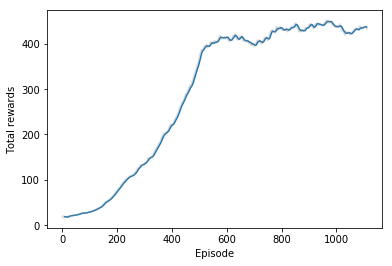

In [26]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

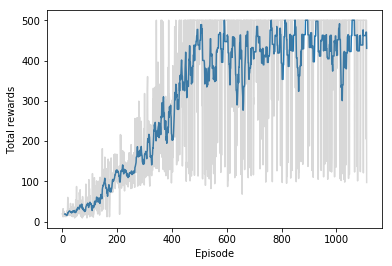

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [28]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

SyntaxError: invalid syntax (<ipython-input-28-a0b0af09d9f3>, line 6)

In [67]:
eps, arr = np.array(dlossA_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

In [ ]:
eps, arr = np.array(dlossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.